In [1]:
# PYTHON Imports 
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pathlib import Path
import glob
import ipywidgets as widgets
from IPython.display import clear_output
import statistics
from astroquery.gaia import Gaia
import pickle

# Specify global path
global_path = '/Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets'


In [6]:
# query = """SELECT 
# TOP 5000000
# source_id, ra, dec, radial_velocity, parallax, bp_rp, phot_g_mean_mag+5*log10(parallax)-10 AS mg
# FROM gaiadr2.gaia_source
# WHERE parallax_over_error > 10
# AND phot_g_mean_flux_over_error>50
# AND phot_rp_mean_flux_over_error>20
# AND phot_bp_mean_flux_over_error>20
# AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
# AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
# AND visibility_periods_used>8
# AND astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5)))
# AND 1000/parallax <=200
# """

query =  """SELECT 
TOP 500000
source_id, ra, dec, radial_velocity, parallax, bp_rp, phot_g_mean_mag+5*log10(parallax)-10 AS mg
FROM gaiadr2.gaia_source
where parallax_over_error > 10
and visibility_periods_used > 8
and phot_g_mean_flux_over_error > 50
and phot_bp_mean_flux_over_error > 20
and phot_rp_mean_flux_over_error > 20
and phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
and phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
and astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5)))
and 1000/parallax <= 200
"""

job = Gaia.launch_job_async(query) #_async
r = job.get_results()
print(type(r))
df = r.to_pandas()
df.to_csv(f'{global_path}/gaiaplot7.csv', index=False)

KeyboardInterrupt: 

In [15]:
# Load the pickle files and read the properties CSV
with open(f'{global_path}/Full/flares-PCA3D.pkl', "rb") as f:
    pca_flares = pickle.load(f)

with open(f'{global_path}/Full/dips-PCA3D.pkl', "rb") as f:
    pca_dips = pickle.load(f)

with open(f'{global_path}/Full/flares-XAE3D.pkl', "rb") as f:
    xae_flares = pickle.load(f)

with open(f'{global_path}/Full/dips-XAE3D.pkl', "rb") as f:
    xae_dips = pickle.load(f)

df_properties_global = pd.read_csv(f'{global_path}/Full/properties-Full.csv')
df_properties_global['obsreg_id'] = df_properties_global['obsid'].astype(str) + '_' + df_properties_global['region_id'].astype(str)
df_flares = df_properties_global[df_properties_global['obsreg_id'].isin(pca_flares + xae_flares)]
df_dips = df_properties_global[df_properties_global['obsreg_id'].isin(pca_dips + xae_dips)]

df_flares.to_csv(f'{global_path}/Full/flare-properties-Full.csv',index=False)
df_dips.to_csv(f'{global_path}/Full/dip-properties-Full.csv',index=False)

print(len(df_flares))
print(len(df_dips))

print(len(df_flares) + len(df_dips))

df_flares_var = df_flares[df_flares['var_index_b']<3]
df_dips_var = df_dips[df_dips['var_index_b']<3]

print(len(df_flares_var)/len(df_flares))
print(len(df_dips_var)/len(df_dips))

4697
4259
8956
0.16648924845646157
0.7318619394223996


In [2]:
print(flares_df.columns)
print(sdss_df.columns)


NameError: name 'flares_df' is not defined

In [7]:
flares_df = pd.read_csv(f'{global_path}/Full/flare-properties-Full.csv')
sdss_df = pd.read_csv(f'{global_path}/Full/CSC2-SDSSDR15_FinalXmatch.csv')
cross_df = pd.merge(flares_df, sdss_df, left_on='name', right_on='CSC2_ID', how= 'inner')

In [9]:
print(len(cross_df))
pd.set_option('display.max_columns', None)
star_df = cross_df[cross_df['SDSSDR15_Type']=='S'].reset_index(drop=True)
galaxy_df = cross_df[cross_df['SDSSDR15_Type']=='G']
print(len(star_df))
print(len(galaxy_df))

201
142
59


In [13]:
import pandas as pd
from astropy.coordinates import SkyCoord
from astropy import units as u

ra_list = flares_df.ra.values
dec_list = flares_df.dec.values

bp_rp_list = []
mg_list = []
d_list = []
index_list = []

counter_total = len(flares_df)
count = 0
match = 0
reject = 0

# Loop over each coordinate
for idx, (ra, dec) in enumerate(zip(ra_list, dec_list)):
    # Convert RA and Dec to astropy.coordinates.SkyCoord
    coord = SkyCoord(ra=ra*u.deg, dec=dec*u.deg, frame='icrs')

    # Query Gaia
    job = Gaia.launch_job_async(f"SELECT * FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS', gaiadr2.gaia_source.ra, gaiadr2.gaia_source.dec), CIRCLE('ICRS', {ra}, {dec}, 0.0005555555555555556))=1;")
    result = job.get_results()

    # Apply filters to select stellar sources
    parallax_min = 
    
    color_index = result['bp_rp']
    mask = (result['parallax'] > parallax_min) & (color_index > -1) & (color_index < 5)
    stars = result[mask]
    stars_df = stars.to_pandas().reset_index(drop=True)

    if len(stars) > 0:
        # Retrieve the closest matched star
        star_coords = SkyCoord(stars['ra'], stars['dec'], frame='icrs')
        distances = coord.separation(star_coords)
        closest_star_index = distances.argmin()
        closest_star = stars_df.iloc[closest_star_index]
        closest_star_coords = SkyCoord(closest_star['ra'], closest_star['dec'], frame='icrs',unit=u.deg)
        matched_stars = Gaia.cone_search_async(closest_star_coords, radius=0.01*u.deg).get_results()
        bp_rp = matched_stars['bp_rp']
        mg = matched_stars['phot_g_mean_mag'] + 5*np.log10(matched_stars['parallax']) - 10
        d = 1000/matched_stars['parallax']

        colo = bp_rp[0]
        mag = mg[0]
        di = d[0]
        print(colo,mag,di,idx)

        # Append the data
        bp_rp_list.append(colo)
        mg_list.append(mag)
        d_list.append(di)
        index_list.append(idx)

        print('MATCH')
        match = match + 1
    else:
        print('NO MATCH')
        reject = reject + 1

    count = count + 1
    print(f'{count}/{counter_total}')
    print(f'Matches: {match}')
    print(f'Rejections: {reject}')

bp_rp_arr = np.ma.array(bp_rp_list)
mg_arr = np.ma.array(mg_list)
d_arr = np.ma.array(d_list)
masked_indices = np.where(bp_rp_arr.mask | mg_arr.mask | d_arr.mask)[0]

bp_rp_list2 = np.delete(bp_rp_list, masked_indices)
mg_list2 = np.delete(mg_list, masked_indices)
d_list2 = np.delete(d_list, masked_indices)
index_list2 = np.delete(index_list,masked_indices)


matched_df = flares_df[flares_df.index.isin(index_list2)]
matched_df['bp_rp'] = bp_rp_list2
matched_df['distance'] = d_list2
matched_df['magnitude'] = mg_list2

matched_df.to_csv(f'{global_path}/gaiaflaresFULL.csv', index=False)




INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
3.0094414 11.910804252893776 548.0150916325022 0
MATCH
1/4697
Matches: 1
Rejections: 0


/var/folders/q1/jbx7qj7s0dxbh7nv02nfvc680000gn/T/ipykernel_7127/909186717.py:43: RuntimeWarning: invalid value encountered in log10
  mg = matched_stars['phot_g_mean_mag'] + 5*np.log10(matched_stars['parallax']) - 10


INFO: Query finished. [astroquery.utils.tap.core]
NO MATCH
2/4697
Matches: 1
Rejections: 1
INFO: Query finished. [astroquery.utils.tap.core]
NO MATCH
3/4697
Matches: 1
Rejections: 2
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
3.1743393 7.00287596655663 1094.3850142755575 3
MATCH
4/4697
Matches: 2
Rejections: 2
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
2.8520355 8.644402014329472 1379.4547929860873 4
MATCH
5/4697
Matches: 3
Rejections: 2
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
3.050726 5.718325143955877 1336.570048670033 5
MATCH
6/4697
Matches: 4
Rejections: 2
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
1.3221931 10.615181469409034 596.1435536589565 6
MATCH
7/4697
Matches: 5
Rejections: 2
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [

In [14]:
df_zz = pd.read_csv(f'{global_path}/gaiaflaresFULL.csv')
df_zz.head()
print(len(df_zz))

import matplotlib.colors as mcolors
imperial = '#003E74'
imperial2 = '#002147'
darkblue = '#003170'
harvard = '#A51C30'
silver = '#777777'
silver2 = '#C0C0C0'
gold = '#cfbd62'
# Create a dictionary that maps values between 0 and 1 to colors
color_dict = {'red':   [(0.0, 1.0, 1.0), (1.0, 1.0, 1.0)],
              'green': [(0.0, 0.0, 0.0), (1.0, 0.0, 0.0)],
              'blue':  [(0.0, 0.0, 0.0), (1.0, 0.0, 0.0)]}
# Create the colormap using the dictionary and the two colors
cmap_h = mcolors.LinearSegmentedColormap.from_list('my_colormap', ['white',gold,harvard,'black'], N=256)
cmap_h2 = mcolors.LinearSegmentedColormap.from_list('my_colormap', ['white',harvard,'black'], N=256)
cmap_h3 = mcolors.LinearSegmentedColormap.from_list('my_colormap', [gold,harvard,'black'], N=256)
cmap_g = mcolors.LinearSegmentedColormap.from_list('my_colormap', ['white',gold,'black'], N=256)

cmap_gg = mcolors.LinearSegmentedColormap.from_list('my_colormap', ['black',gold], N=256)
cmap_ggg = mcolors.LinearSegmentedColormap.from_list('my_colormap', ['black',gold,'white'], N=256)
cmap_hhh = mcolors.LinearSegmentedColormap.from_list('my_colormap', ['black',harvard,'white'], N=256)

2517


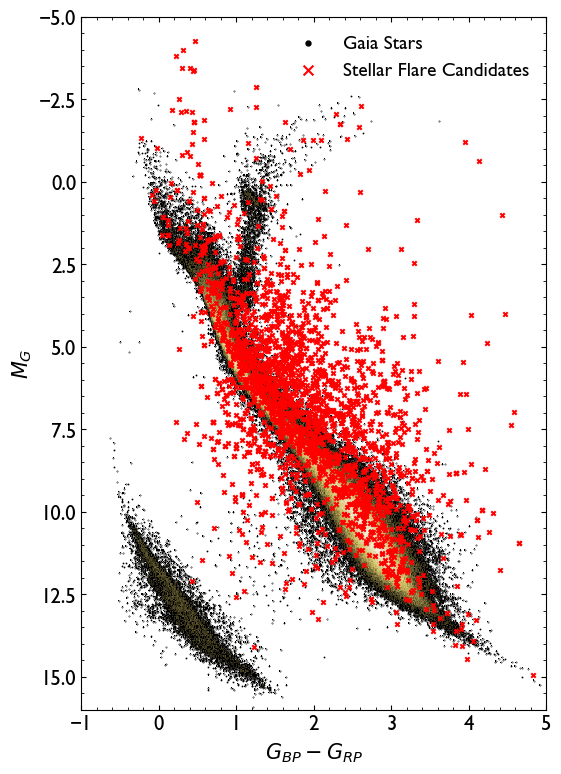

In [16]:
# df = pd.read_csv(f'{global_path}/gaiaplot7.csv')
df = pd.read_csv(f'{global_path}/gaiaplot6.csv')

bp_rp = df['bp_rp'].values
mg = df['mg'].values
d = 1000/df['parallax'].values

bp_rp_z = df_zz['bp_rp']
mg_z = df_zz['magnitude']
# Define Font Settings

sizefont = 15
sizefont2 = 14
plt.rcParams.update({'font.size': sizefont})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Gill Sans'

fig, ax = plt.subplots(figsize = (6,9))
h = ax.hist2d(bp_rp, mg, bins=500, cmin=1, norm=colors.PowerNorm(0.5), zorder=0.5,cmap = cmap_ggg) #binary_r cmap_ggg
ax.scatter(bp_rp, mg, s=0.1, color='black', zorder=0,label = 'SDSS & Gaia Stars')
ax.set_xlabel(r"$G_{BP} - G_{RP}$")
ax.set_ylabel(r"$M_G$")
# ax.set_xlim(-1, 5)
# ax.set_ylim(20, -5)
ax.set_xlim(-1, 5)
ax.set_ylim([16, -5])
ax.minorticks_on()
# Display axis ticks on all sides
ax.tick_params(which='both', direction='in', top=True, right=True)
# Turn on the border of the plot
# for spine in ax.spines.values():
#     spine.set_linewidth(1)
ax.scatter(bp_rp_z, mg_z, c='red',marker ='x',label = 'Stellar Flares',s=10)

custom_markers = [plt.scatter([], [], marker='.', color='black', edgecolor='black', s=50),
                  plt.scatter([], [], marker='x', color='red', s=50)]

legend = ax.legend(handles=custom_markers, labels=['Gaia Stars', 'Stellar Flare Candidates'], loc='upper right', frameon=False,fontsize=14)


196078.431372549
-2.130849119510316
[0.8381, 0.6023, 1.9233, 2.0485, 2.3551, 1.7588, 3.2988, 2.3687, 2.3144, 0.7637, 0.0586, 1.0224, 2.7417, 2.9747, 1.2151, 1.1712, 1.1776, 0.6663]
[ 4.55742238  3.61629244 11.79431981  8.64853744  7.83284005  6.1594492
 11.67861593         nan  3.25629026  4.81172009  1.08898629  4.51602112
 11.5549238  11.81423881  2.55330911  5.55107642 -2.13084912  9.52819774]


/var/folders/q1/jbx7qj7s0dxbh7nv02nfvc680000gn/T/ipykernel_89876/922587432.py:33: RuntimeWarning: invalid value encountered in log10
  M = m+5*np.log10(p)-10


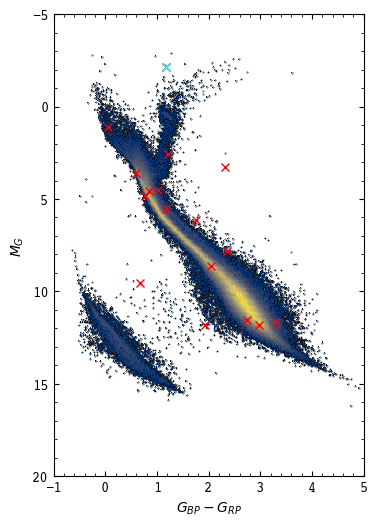

[8.81398724285941e+35, 7.760928331287409e+31, 5.198453700380347e+36, 4.1415880482348626e+33]
[230.25045044042346, 0.020274107448504202, 1358.0077587200487, 1.0819195528304237]


In [5]:
# df = pd.read_csv(f'{global_path}/gaiaplot7.csv')
df = pd.read_csv(f'{global_path}/gaiaplot6.csv')
bp_rp = df['bp_rp'].values
mg = df['mg'].values
d = 1000/df['parallax'].values
# Define Font Settings
plt.rcParams.update({'font.size': 10})
plt.rcParams['font.monospace'] = "Courier"
plt.rcParams["font.family"] = "monospace"

fig, ax = plt.subplots(figsize = (4,6))
h = ax.hist2d(bp_rp, mg, bins=500, cmin=1, norm=colors.PowerNorm(0.5), zorder=0.5,cmap = 'cividis')
ax.scatter(bp_rp, mg, s=0.1, color='black', zorder=0)
ax.set_xlabel(r"$G_{BP} - G_{RP}$")
ax.set_ylabel(r"$M_G$")
ax.set_xlim(-1, 5)
ax.set_ylim(20, -5)
ax.minorticks_on()
# Display axis ticks on all sides
ax.tick_params(which='both', direction='in', top=True, right=True)
# Turn on the border of the plot
# for spine in ax.spines.values():
#     spine.set_linewidth(1)

### ON TOP POINTS

name = []
p = []
m = []
bprp = []

print(1000/0.0051)
M = m+5*np.log10(p)-10

print(19.3313 - 5 * np.log10(196078.431372549/10))


#Gaia DR3 4661828254113382784
# Gaia DR3 4661828249815490688
print(bprp)
print(M)

ax.plot(bprp, M, c='red',marker ='x',linestyle='none')
ax.plot(bprp[-2], M[-2], c='cyan',marker ='x',linestyle='none')

plt.show()


#FXT LUMINOSITY
import math

flux = 1.916E-13  # erg/s/cm²
parallaxes = [0.0051, 0.5435, 0.0021, 0.0744]  # mas

# Convert parallaxes from mas to as
parallaxes = [p / 1000 for p in parallaxes]

solar_luminosity = 3.828E33
luminosities = []
for parallax in parallaxes:
    distance = 1 / parallax
    distance_cm = distance * 3.0857E18  # Convert parsecs to cm
    luminosity = 4 * math.pi * (distance_cm ** 2) * flux
    luminosities.append(luminosity)

luminosities_sun  =[l/ solar_luminosity for l in luminosities]

print(luminosities)
print(luminosities_sun)

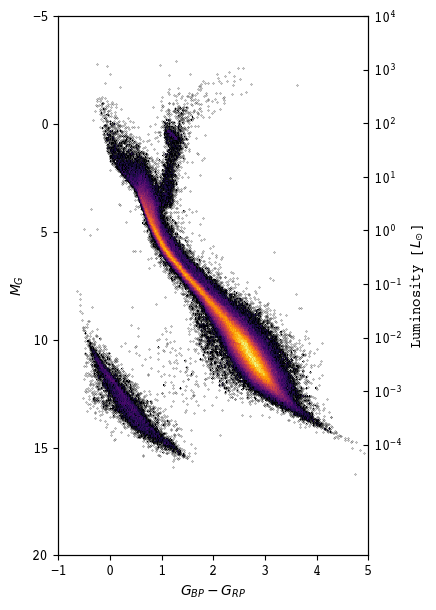

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

df = pd.read_csv(f'{global_path}/gaiaplot6.csv')
bp_rp = df['bp_rp'].values
mg = df['mg'].values
d = 1000/df['parallax'].values

Teff = 8907.2 / (0.92 * (bp_rp) + 1.7)
# M = mg - 5 * log10(d/10)
# L = 10**((4.83 - M) / 2.5)

Lum = 10**(-(mg-4.83)/2.5) #* (d/10)**2

fig, ax = plt.subplots(figsize = (4,7))

h = ax.hist2d(bp_rp, mg, bins=300, cmin=2, norm=colors.PowerNorm(0.5), zorder=0.5,cmap = 'inferno')
ax.scatter(bp_rp, mg, s=0.05, color='black', zorder=0)
ax.set_xlabel(r"$G_{BP} - G_{RP}$")
ax.set_ylabel(r"$M_G$")
ax.set_xlim(-1, 5)
ax.set_ylim(20, -5)

# # Add temperature axis on top
# ax2 = ax.twiny()
# ax2.set_xlabel("Effective temperature [K]")
# ax2.set_xlim(30000, 1000)
# ax2.set_xscale('log')
# ax2.set_xticks([30000, 7000, 5000, 4000, 3000, 2000, 1000])
# ax2.tick_params(axis='x', which='major', direction='in')
# ax2.invert_xaxis()

# Add luminosity axis on right
ax3 = ax.twinx()
ax3.set_ylabel("Luminosity [$L_{\odot}$]")
ax3.set_ylim(10**(-(-5-4.83)/2.5), 10**(-(20-4.83)/2.5))
ax3.set_yscale('log')
ax3.set_yticks([10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001])
ax3.tick_params(axis='y', which='major', direction='in')
ax3.invert_yaxis()

plt.show()



    # d = r['distance'].data
# Teff = 8907.2 / (0.92 * (bp_rp) + 1.7)
# Lum = 10**(-(mg-4.83)/2.5) * (d/10)**2
# #https://www.aanda.org/articles/aa/full_html/2018/08/aa32843-18/aa32843-18.html GAIAI citation
# #Casagrande et al. (2018) 
# https://vlas.dev/post/gaia-dr2-hrd/

AttributeError: 'Axes' object has no attribute 'secondary_axis'

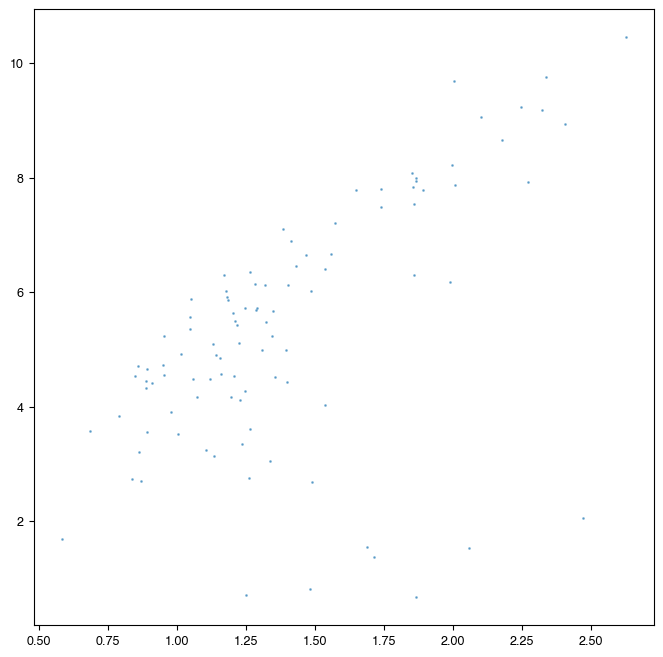

In [26]:
# Your existing code to plot the HR diagram
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(bp_rp, mg, s=1, alpha=0.5, edgecolors=None)
# Plot the transformed data on the new axis
ax2 = ax.secondary_axis('right', functions=(lambda x: x, lambda x: x))
ax2.set_ylabel('Effective Temperature (K)')

# Plot the transformed data on the new axis
ax2 = ax.secondary_axis('right', functions=(lambda x: x, lambda x: x))
ax2.set_ylabel('Effective Temperature (K)')

ax2.scatter(L, T_eff, s=1, alpha=0.5, edgecolors=None)

# Set the limits of the new axis to match the limits of the HR diagram
ax2.set_ylim(ax.get_ylim())

# Add a label to the new axis
ax2.yaxis.set_label_position('right')
ax2.yaxis.label.set_color('C1')
ax2.tick_params(axis='y', colors='C1')
ax2.spines['right'].set_color('C1')
ax2.spines['left'].set_visible(False)

In [ ]:
def send_radial_gaia_query(query_size=1000, **kwargs):
    """
    Sends an archive query for d < 200 pc, with additional filters taken from
    Gaia Data Release 2: Observational Hertzsprung-Russell diagrams (Sect. 2.1)
    Gaia Collaboration, Babusiaux et al. (2018)
    (https://doi.org/10.1051/0004-6361/201832843)

    NOTE: 10000000 is a maximum query size (~76 MB / column)

    Additional keyword arguments are passed to TapPlus.launch_job_async method.
    """

    job = Gaia.launch_job_async("SELECT TOP {}".format(query_size)+
        "source_id, ra, dec, radial_velocity, bp_rp, phot_g_mean_mag+5*log10(parallax)-10 AS mg, 1000/parallax AS distance" 
        "FROM gaiadr2.gaia_source"
        "WHERE parallax_over_error > 10"
        "AND phot_g_mean_flux_over_error>50"
        "AND phot_rp_mean_flux_over_error>20"
        "AND phot_bp_mean_flux_over_error>20"
        "AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2)"
        "AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2)"
        "AND visibility_periods_used>8"
        "AND astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5)))")

    return job

try:
    gaiarec = np.recfromcsv(f'{global_path}/gaia-hrd-dr2-200pc.csv')
    bp_rp, mg = gaiarec.bp_rp, gaiarec.mg#, gaiarec.distance
except OSError:
    job = send_radial_gaia_query(dump_to_file=True, output_format="csv",
                                    output_file=f'{global_path}/gaia-hrd-dr2-200pc.csv',
                                    query_size=10)
    r = job.get_results()
    bp_rp = r['bp_rp'].data
    mg = r['mg'].data
    # d = r['distance'].data
d = 200 * len(mg)
# Teff = 8907.2 / (0.92 * (bp_rp) + 1.7)
# Lum = 10**(-(mg-4.83)/2.5) * (d/10)**2
#https://www.aanda.org/articles/aa/full_html/2018/08/aa32843-18/aa32843-18.html GAIAI citation
#Casagrande et al. (2018)

# Define function to convert absolute magnitude to luminosity
def abs_mag_to_luminosity(abs_mag, distance):
    M_sun = 4.83
    L_sun = 3.828e26 # in Watts
    return L_sun * 10**(-0.4*(abs_mag - M_sun)) / (4 * np.pi * (distance * 3.086e+16)**2)

# Define function to convert bp-rp to effective temperature
def bp_rp_to_Teff(bp_rp):
    a = 3.939
    b = 0.6528
    c = 0.0603
    return 4600 * np.power(1/(a + b*np.log10(bp_rp) + c*np.power(np.log10(bp_rp), 3)), 1/2)
def Teff_to_bp_rp(Teff):
    a = 3.939
    b = 0.6528
    c = 0.0603
    return np.power(10, (a - np.log10(Teff/4600)) / b + c*np.log10(Teff/4600))


# Convert absolute magnitude to luminosity
L = abs_mag_to_luminosity(mg, d)
# Convert bp-rp to effective temperature
Teff = bp_rp_to_Teff(bp_rp)

# Plot the HR diagram
fig, ax = plt.subplots()
ax.scatter(bp_rp, mg, s=0.1, color='black')
ax.set_xlabel(r"$G_{BP} - G_{RP}$")
ax.set_ylabel(r"$M_G$")
ax.set_xlim(-0.5, 4)
ax.set_ylim(15, -5)

# Set the limits and ticks for the new axis
axT = ax.twiny()
bp_rp_min, bp_rp_max = axT.get_xlim()
axT.set_xlim(bp_rp_to_Teff(bp_rp_min), bp_rp_to_Teff(bp_rp_max))
Teff_ticks = np.array([3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000])
bp_rp_ticks = Teff_to_bp_rp(Teff_ticks)
axT.set_xticks(bp_rp_ticks)
axT.set_xticklabels(Teff_ticks)

# Set the label for the new axis
axT.set_xlabel('Effective Temperature (K)', fontsize=12)

# Add gridlines for the new axis
axT.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

# # Define the secondary axis for luminosity
# def luminosity_to_abs_mag(luminosity, distance):
#     M_sun = 4.83
#     L_sun = 3.828e26 # in Watts
#     return M_sun - 2.5*np.log10(luminosity/(L_sun/(4*np.pi*(distance*3.086e+16)**2)))

# def luminosity_formatter(x, pos):
#     abs_mag = luminosity_to_abs_mag(x, d)
#     return f'{x:.1e}\nM/Msun\n(M_G={abs_mag:.2f})'

# ax.secondary_yaxis('right', functions=(luminosity_to_abs_mag, luminosity_formatter))
# ax.set_ylim(ax.get_ylim()[::-1]) # flip the y-axis

# # Define the tertiary axis for Teff
# def Teff_to_bp_rp(Teff):
#     a = 3.939
#     b = 0.6528
#     c = 0.0603
#     x = np.power((4600/Teff),2) - a
#     y = b*np.log10(bp_rp) + c*np.power(np.log10(bp_rp), 3)
#     return np.power(x/y,1/2)

# def Teff_formatter(x, pos):
#     return f'{x:.0f}\nK'

# ax.secondary_xaxis('top', functions=(Teff_to_bp_rp, Teff_formatter))

$\tau$ Bins


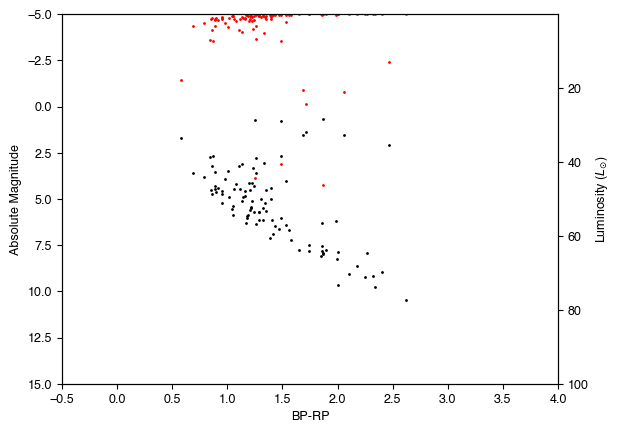

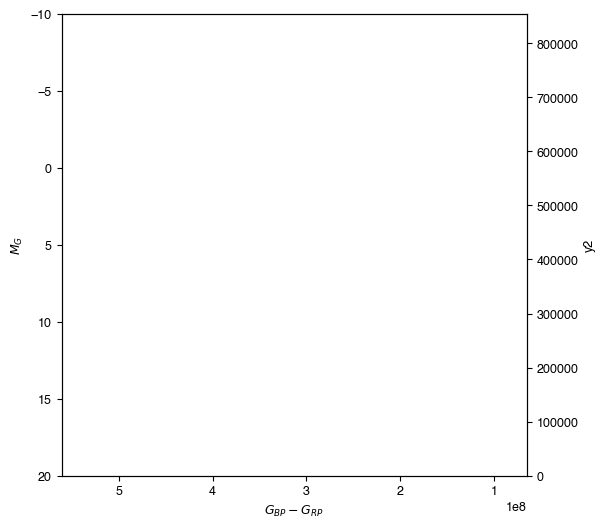

In [25]:
# Define Font Settings
plt.rcParams.update({'font.size': 9})
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams['font.family'] = 'sans-serif'
print(r'$\tau$ Bins')

# Plot the HR diagram
fig, ax1 = plt.subplots()
ax1.plot(bp_rp, mg, 'o', markersize=1, color='black')
ax1.set_xlim(-0.5, 4)
ax1.set_ylim(15, -5)
# ax1.set_xlim(-1,5)
# ax1.set_ylim(20,-10)
ax1.set_xlabel('BP-RP')
ax1.set_ylabel('Absolute Magnitude')

# Add the second axis for luminosity
ax2 = ax1.twinx()
ax2.plot(bp_rp, L, 'o', markersize=1, color='red')
ax2.set_ylim(100, 0.001)
ax2.set_ylabel('Luminosity ($L_{\odot}$)')



fig, ax = plt.subplots(figsize=(6, 6))
# only show 2D-histogram for bins with more than 10 stars in them
# h = ax.hist2d(bp_rp, mg, bins=300, cmin=10, norm=colors.PowerNorm(0.5), zorder=0.5)
# fill the rest with scatter (set rasterized=True if saving as vector graphics)
ax.scatter(bp_rp, mg, alpha=0.5, s=10, color='k', zorder=0)
ax.invert_yaxis()
# cb = fig.colorbar(h[3], ax=ax, pad=0.02)
ax.set_xlabel(r"$G_{BP} - G_{RP}$")
ax.set_ylabel(r"$M_G$")
ax.set_xlim(-1,5)
ax.set_ylim(20,-10)

# Create the second axis and plot y2
ax2 = ax.twinx()
ax2.set_ylabel('y2')
ax2.set_ylabel('y2')

# Set the limits of the second axis based on the limits of the first axis
y1_min, y1_max = ax.get_ylim()
y2_min = 10**((4.83 - y1_min)/2.5)
y2_max = 10**((4.83 - y1_max)/2.5)
x1_min, x1_max = ax.get_ylim()
x2_min = (4370 * x1_min ** 4) - (18620 * x1_min ** 3) + (27834 * x1_min ** 2) - (16172 * x1_min) + 3251.4
x2_max = (4370 * x1_max ** 4) - (18620 * x1_max ** 3) + (27834 * x1_max ** 2) - (16172 * x1_max) + 3251.4
ax2.set_ylim(y2_max, y2_min)
ax2.set_xlim(x2_min, x2_max)
# cb.set_label(r"$\mathrm{Stellar~density}$")
plt.show()


In [ ]:
# def send_radial_gaia_query(query_size=1000, **kwargs):
#     """
#     Sends an archive query for d < 200 pc, with additional filters taken from
#     Gaia Data Release 2: Observational Hertzsprung-Russell diagrams (Sect. 2.1)
#     Gaia Collaboration, Babusiaux et al. (2018)
#     (https://doi.org/10.1051/0004-6361/201832843)

#     NOTE: 10000000 is a maximum query size (~76 MB / column)

#     Additional keyword arguments are passed to TapPlus.launch_job_async method.
#     """

#     job = Gaia.launch_job("SELECT TOP {}".format(query_size)+
#         "source_id, ra, dec, radial_velocity, bp_rp, parallax, phot_g_mean_mag+5*log10(parallax)-10 AS mg" 
#         "FROM gaiadr2.gaia_source"
#         "WHERE parallax_over_error > 10"
#         "AND phot_g_mean_flux_over_error>50"
#         "AND phot_rp_mean_flux_over_error>20"
#         "AND phot_bp_mean_flux_over_error>20"
#         "AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2)"
#         "AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2)"
#         "AND visibility_periods_used>8"
#         "AND astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5)))")

#     return job

# try:
#     gaiarec = np.recfromcsv(f'{global_path}/gaia-hrd-dr2-200pc.csv')
#     bp_rp, mg, par = gaiarec.bp_rp, gaiarec.mg, gaiarec.parallax
#     d = 1000/par
# except OSError:
#     job = send_radial_gaia_query(dump_to_file=True, output_format="csv",
#                                     output_file=f'{global_path}/gaia-hrd-dr2-200pc.csv',
#                                     query_size=1000)
#     r = job.get_results()
#     bp_rp = r['bp_rp'].data
#     mg = r['mg'].data
#     par = r['parallax'].data
#     d = 1000/par

In [19]:
def send_radial_gaia_query(query_size=100, distance=200, **kwargs):
    """
    Sends an archive query for d < 200 pc, with additional filters taken from
    Gaia Data Release 2: Observational Hertzsprung-Russell diagrams (Sect. 2.1)
    Gaia Collaboration, Babusiaux et al. (2018)
    (https://doi.org/10.1051/0004-6361/201832843)

    NOTE: 10000000 is a maximum query size (~76 MB / column)

    Additional keyword arguments are passed to TapPlus.launch_job_async method.
    """

    job = Gaia.launch_job_async("select top {}".format(query_size)+
                #" lum_val, teff_val,"
                #" ra, dec, parallax,"
                " bp_rp, phot_g_mean_mag+5*log10(parallax)-10 as mg"
         " from gaiadr2.gaia_source"
         " where parallax_over_error > 10"
         " and visibility_periods_used > 8"
         " and phot_g_mean_flux_over_error > 50"
         " and phot_bp_mean_flux_over_error > 20"
         " and phot_rp_mean_flux_over_error > 20"
         " and phot_bp_rp_excess_factor <"
            " 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2)"
         " and phot_bp_rp_excess_factor >"
            " 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2)"
         " and astrometric_chi2_al/(astrometric_n_good_obs_al-5)<"
            "1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5)))"
         +" and 1000/parallax <= {}".format(distance), **kwargs)

    return job

try:
    gaiarec = np.recfromcsv(f'{global_path}/gaia-hrd-dr2-200pc.csv')
    bp_rp, mg = gaiarec.bp_rp, gaiarec.mg
except OSError:
   job = send_radial_gaia_query(dump_to_file=True, output_format="csv",
                                 output_file=f'{global_path}/gaia-hrd-dr2-200pc.csv',
                                 query_size=100)
r = job.get_results()
bp_rp = r['bp_rp'].data
mg = r['mg'].data

HTTPError: Moved Temporarily

In [ ]:
# plot the H-R diagram for 1 M stars within 200 pc from the Sun
import matplotlib.pyplot as plt
from matplotlib import colors
plt.rc('text', usetex=True)

fig, ax = plt.subplots(figsize=(6, 6))
# only show 2D-histogram for bins with more than 10 stars in them
h = ax.hist2d(bp_rp, mg, bins=300, cmin=10, norm=colors.PowerNorm(0.5), zorder=0.5)
# fill the rest with scatter (set rasterized=True if saving as vector graphics)
ax.scatter(bp_rp, mg, alpha=0.05, s=1, color='k', zorder=0)
ax.invert_yaxis()
cb = fig.colorbar(h[3], ax=ax, pad=0.02)
ax.set_xlabel(r'$G_{BP} - G_{RP}$')
ax.set_ylabel(r'$M_G$')
cb.set_label(r"$\mathrm{Stellar~density}$")
plt.show()

In [68]:
#https://datacarpentry.org/astronomy-python/aio/index.html
tables = Gaia.load_tables(only_names=True)
# for table in tables:
#     print(table.name)
table_metadata = Gaia.load_table('gaiadr2.gaia_source')
print(table_metadata)
# for column in table_metadata.columns:
#     print(column.name)
panstarrs_metadata = Gaia.load_table('gaiadr2.panstarrs1_original_valid')
print(panstarrs_metadata)
query1 = """SELECT 
TOP 2000
source_id, ra, dec, radial_velocity, bp_rp, parallax
FROM gaiadr2.gaia_source
"""
job1 = Gaia.launch_job(query1)
job1
results1 = job1.get_results()
type(results1)
results1
from astropy.table import Table




INFO: Retrieving tables... [astroquery.utils.tap.core]
INFO: Parsing tables... [astroquery.utils.tap.core]
INFO: Done. [astroquery.utils.tap.core]
Retrieving table 'gaiadr2.gaia_source'
TAP Table name: gaiadr2.gaiadr2.gaia_source
Description: This table has an entry for every Gaia observed source as listed in the
Main Database accumulating catalogue version from which the catalogue
release has been generated. It contains the basic source parameters,
that is only final data (no epoch data) and no spectra (neither final
nor epoch).
Num. columns: 95
Retrieving table 'gaiadr2.panstarrs1_original_valid'
TAP Table name: gaiadr2.gaiadr2.panstarrs1_original_valid
Description: The Panoramic Survey Telescope and Rapid Response System (Pan-STARRS) is
a system for wide-field astronomical imaging developed and operated by
the Institute for Astronomy at the University of Hawaii. Pan-STARRS1
(PS1) is the first part of Pan-STARRS to be completed and is the basis
for Data Release 1 (DR1). The PS1 surve